In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ehtim as eh

import jax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from utils import NeuralImage, train_step


Loading text image:  datasets/avery_sgra_eofn.txt


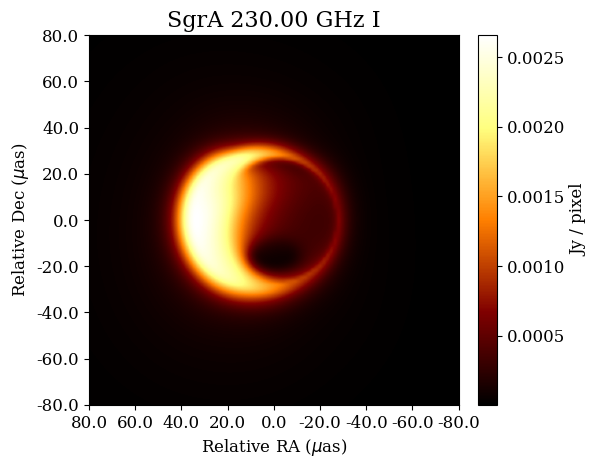

2025-06-30 20:40:19.558628: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 11546394624


In [2]:
image_path = 'datasets/avery_sgra_eofn.txt'
array_path = 'datasets/EHT2017.txt'
image_true = eh.image.load_txt(image_path)
array = eh.array.load_txt(array_path)
image_true.display()

intensity_gt = jnp.array(image_true.imarr(), dtype=jnp.float32)
ydim, xdim = intensity_gt.shape
assert intensity_gt.size == image_true.imvec.size

x, y = np.linspace(0, 1, xdim), np.linspace(0, 1, ydim)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='xy')), 0, -1)

coords_flat = coords.reshape(-1,2)
gt_flat = intensity_gt.ravel()

In [3]:
mask = coords_flat[:, 0] > 0.5
coords_train = coords_flat[~mask]
Y_train_true = gt_flat[~mask] # no noise applied

coords_test = coords_flat[mask]
Y_test_true = gt_flat[mask] #no noise applied

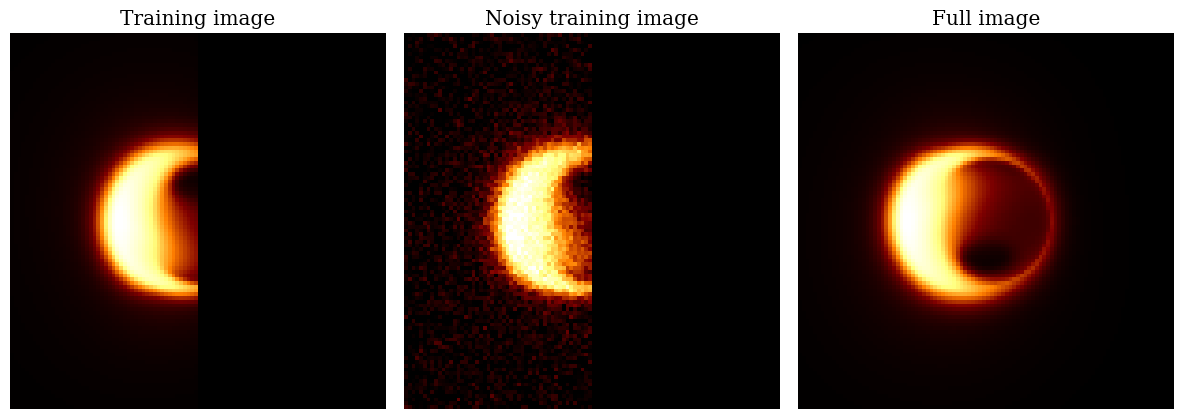

In [4]:
rng = jax.random.PRNGKey(42)
noise = 0.05 * jnp.max(jnp.abs(Y_train_true))

#add gaussian noise
Y_train = Y_train_true + noise * jax.random.normal(rng, Y_train_true.shape)
sigma_vec = jnp.full_like(Y_train, noise)

# plot
full_clean = jnp.zeros(xdim*ydim)
full_noisy = jnp.zeros(xdim*ydim)

full_clean = full_clean.at[~mask].set(Y_train_true)
full_noisy = full_noisy.at[~mask].set(Y_train)

I_clean = full_clean.reshape(ydim, xdim)
I_noisy = full_noisy.reshape(ydim, xdim)

vmin, vmax = float(I_clean.min()), float(I_clean.max())
fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow(I_clean, cmap='afmhot', vmin=vmin, vmax=vmax, origin='lower')
ax[0].set_title("Training image")
ax[1].imshow(I_noisy, cmap='afmhot', vmin=vmin, vmax=vmax, origin='lower')
ax[1].set_title("Noisy training image")
ax[2].imshow(intensity_gt, cmap='afmhot')
ax[2].set_title("Full image")

for a in ax: 
    a.axis('off')
plt.tight_layout()
plt.show()

In [5]:
predictor = NeuralImage(posenc_deg=3, net_depth=4, net_width=128, activation=nn.relu, out_channel=1, do_skip=True)

hparams = {'num_iters': 10000, 'lr_init': 1e-3, 'lr_final': 1e-4, 'batchsize': 1000}

params = predictor.init(rng, coords)['params']
tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
state = train_state.TrainState.create(apply_fn=predictor.apply, params=params, tx=tx)

for i in tqdm(range(hparams['num_iters']), desc='iteration'):
    batch = np.random.choice(range(len(coords_train)), hparams['batchsize'], replace=False)
    loss, state, image = train_step(state, Y_train[batch], coords_train[batch])
    if i % 1000 == 0:
        print(f"iteration {i}, loss={loss:.5f}")


iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

iteration 0, loss=0.57437
iteration 1000, loss=0.00000
iteration 2000, loss=0.00000
iteration 3000, loss=0.00000
iteration 4000, loss=0.00000
iteration 5000, loss=0.00000
iteration 6000, loss=0.00000
iteration 7000, loss=0.00000
iteration 8000, loss=0.00000
iteration 9000, loss=0.00000


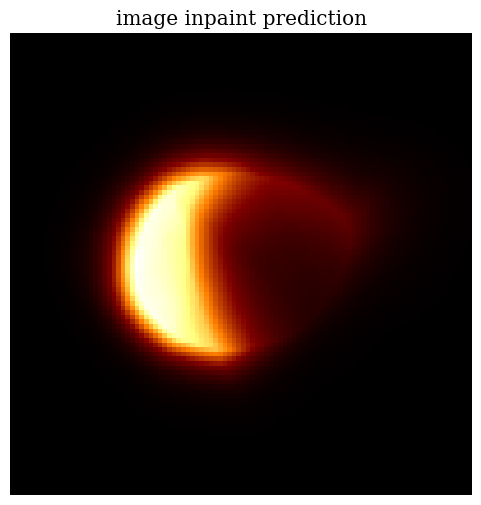

In [6]:
full_image = predictor.apply({'params': state.params}, coords)
full_image = np.array(full_image)
plt.figure(figsize=(6,6))
plt.imshow(full_image, cmap='afmhot', origin='lower')
plt.axis('off')
plt.title('image inpaint prediction')
plt.show()

In [7]:
def bilinear(coords, theta):
    """gpt generated function to fill in for now"""
    gx, gy, _ = theta.shape
    # scale to vertex index space
    x = coords[..., 0] * (gx - 1)
    y = coords[..., 1] * (gy - 1)

    i0 = jnp.floor(x).astype(jnp.int32)
    j0 = jnp.floor(y).astype(jnp.int32)
    i1 = jnp.clip(i0 + 1, 0, gx - 1)
    j1 = jnp.clip(j0 + 1, 0, gy - 1)

    wx = x - i0
    wy = y - j0

    # gather four corners
    t00 = theta[i0, j0]      # lower-left
    t10 = theta[i1, j0]      # lower-right
    t01 = theta[i0, j1]      # upper-left
    t11 = theta[i1, j1]      # upper-right

    return ((1 - wx) * (1 - wy))[..., None] * t00 + \
           (     wx  * (1 - wy))[..., None] * t10 + \
           ((1 - wx) *      wy )[..., None] * t01 + \
           (     wx  *      wy )[..., None] * t11

class DeformationGrid(nn.Module):
    resolution: tuple[int, ...]

    @nn.compact
    def __call__(self, coords):
        theta = self.param(
            'theta', 
            nn.initializers.zeros, 
            self.resolution + (coords.shape[-1],)
        )
        return bilinear(coords, theta)

def forward_with_deform(params_img, params_def, coords):
    offsets = DeformationGrid.apply({'params': params_def}, coords)
    return predictor.apply({'params': params_img}, coords + offsets)

grid_res = (64, 64)
def_grid = DeformationGrid(grid_res)

In [8]:
"""prepare variables for bayes rays"""
npix = ydim
params_def = def_grid.init(
    jax.random.PRNGKey(0),
    jnp.array([[0, 0]]))['params']
params_def = jax.tree_util.tree_map(jnp.zeros_like, params_def)

params_img = state.params
params_img_frozen = jax.tree_util.tree_map(jnp.array, params_img)

$$I(\theta) = \frac{4}{\sigma^2} \sum_n J^TJ

In [9]:
#implement bayes rays
def forward_offset(params_def, coords):
    """
    add offset and get updated visibility matrix
    """
    offsets = def_grid.apply({'params': params_def}, coords)
    img_pred = predictor.apply({'params': params_img_frozen}, coords + offsets)
    return img_pred

def f_scalar(params_def, coord):
    return forward_offset(params_def, coord[None, :])[0]

def grad_row(params_def, coord):
    g_tree = jax.grad(f_scalar)(params_def, coord)
    return g_tree['theta']

@jax.jit
def chunk(params_def, coords_batch):
    jacobian = jax.vmap(grad_row, in_axes=(None, 0))(params_def, coords_batch)
    return jnp.sum(jacobian**2, axis=0) 

def fisher_sum(chunk_size, res):
    """
    Can no longer assume sigma^2 = 1/2 or use abs in loss fn. Take the derivative of the real and imaginary parts
    and compute in chunks of rows to avoid OOM. 
    
    Args:
        chunk_size: number of rows of the jacobian to evaluate in one step
        res: grid resolution, (xdim, ydim); 2D for now
    Returns:
        J_sq: = sum( (J_re_n^2 + J_im_n^2) / sigma_n^2)
    """
    J_sq = jnp.zeros(grid_res + (2,))
    nvis = coords_train.shape[0]
    for start in range(0, nvis, chunk_size):
        end = min(start + chunk_size, nvis)
        J_sq += chunk(params_def, coords_train[start:end])
    return J_sq

[0.00013282 0.00013282 0.00013282 ... 0.00013282 0.00013282 0.00013282]


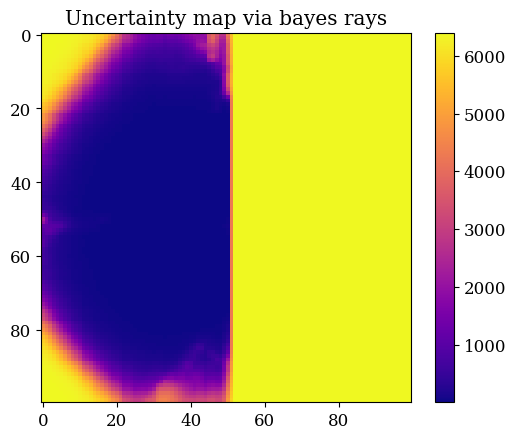

In [ ]:
chunk_size = 8
J_sq = fisher_sum(chunk_size, grid_res)

lam = 1e-4 / (grid_res[0]*grid_res[1])
H_diag = (4/noise**2)*(J_sq/coords_flat.shape[0]) + 2.0 * lam # deterministic H, no monte carlo
variance_grid = 1 / H_diag
sigma_map = jnp.linalg.norm(
    jnp.sqrt(bilinear(coords, variance_grid)), 
    axis=-1
)

plt.figure()
plt.imshow(sigma_map, cmap='plasma')
plt.title("Uncertainty map via bayes rays")
plt.colorbar()
plt.show()